In [783]:
import pandas as pd
import numpy as np
import re
import nltk
import pymorphy2
import math
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [784]:
#nltk.download("stopwords")

In [785]:
stopWords = stopwords.words("russian")
stopWords.append("это")
stopWords.append("де")
stopWords.append("говорить")
stopWords.append("сказать")

morph = pymorphy2.MorphAnalyzer(lang='ru')

In [786]:
def read_files(filename, format):
    i = 1
    dataArr = []
    while True:
        try:
            fd = open(filename + str(i) + format, encoding="utf-8")
        except Exception:
            break
        
        dataArr.append([i, fd.read()])
        
        fd.close()
        i += 1
    return dataArr

In [787]:
def delete_stop_words(text):
    return [word for word in text if word not in stopWords]

def format_data(text):
    fmtTextStr = re.sub(r'[^\w\s]', ' ', text.lower(), flags=re.UNICODE)
    tokenTextArr = nltk.word_tokenize(fmtTextStr)
    cleanTextArr = delete_stop_words(tokenTextArr)
    return " ".join(cleanTextArr)


In [788]:
def get_normalFormStr(line):
    return " ".join([morph.parse(word)[0].normal_form for word in line.split() if morph.parse(word)[0].normal_form not in stopWords])

In [789]:
rusFTaleArr = read_files("../data/rus_", ".txt")
scanFTaleArr = read_files("../data/scan_", ".txt")   # скандинавские сказки
kazFTaleArr = read_files("../data/kaz_", ".txt")    # казахские
norFTaleArr = read_files("../data/nor_", ".txt")   # народы севера


In [790]:
dfRusFTale = pd.DataFrame(rusFTaleArr, columns=['num_doc', 'text'])
dfRusFTale["class"] = "rus"

dfScanFTale = pd.DataFrame(scanFTaleArr, columns=['num_doc', 'text'])
dfScanFTale["class"] = "scan"

dfKazFTale = pd.DataFrame(kazFTaleArr, columns=['num_doc', 'text'])
dfKazFTale["class"] = "kaz"

dfNorFTale = pd.DataFrame(norFTaleArr, columns=['num_doc', 'text'])
dfNorFTale["class"] = "nor"

In [791]:
dfFTales = pd.concat([dfScanFTale, dfKazFTale, dfNorFTale])
dfFTales.head(10)

,num_doc,text,class
0,1,"На краю деревни, у околицы стоял одинокий поко...",scan
1,2,"Жил когда-то в Финнмарке человек, который пойм...",scan
2,3,Жил на свете крестьянин по имени Гудбранд. Уса...,scan
3,4,Жили в одном селе две вздорные соседки. Стоило...,scan
4,5,"В одной деревне жил у отца с матерью парень, п...",scan
5,6,"Жила-была старая женщина, и был у нee сын женщ...",scan
6,7,Задумал один крестьянский парень жениться. И х...,scan
7,8,Жила в Треннелагской округе бедная женщина. Не...,scan
8,9,Как-то раз под вечер одна Курица взлетела на в...,scan
9,10,В стародавние времена у одного короля было две...,scan


In [792]:
dfFTales["formated"] = dfFTales.text.apply(lambda textFTale: get_normalFormStr(format_data(textFTale)))
dfFTales["formated_withoutMorph"] = dfFTales.text.apply(lambda textFTale: format_data(textFTale))

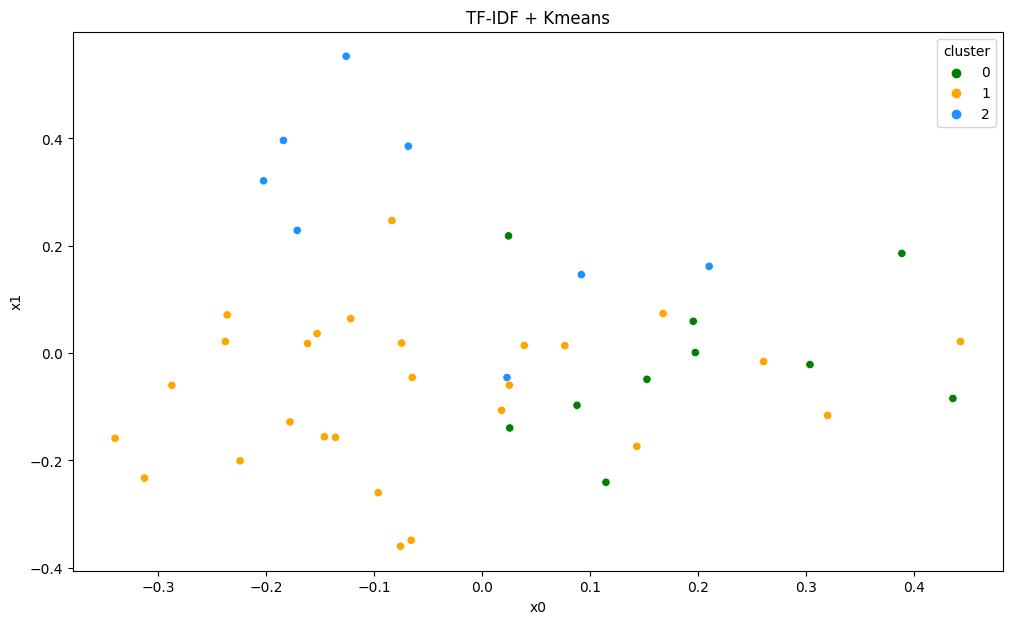

0.6111111111111112
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.58      0.78      0.67         9
           2       0.75      0.75      0.75         4

    accuracy                           0.61        18
   macro avg       0.61      0.58      0.57        18
weighted avg       0.60      0.61      0.58        18



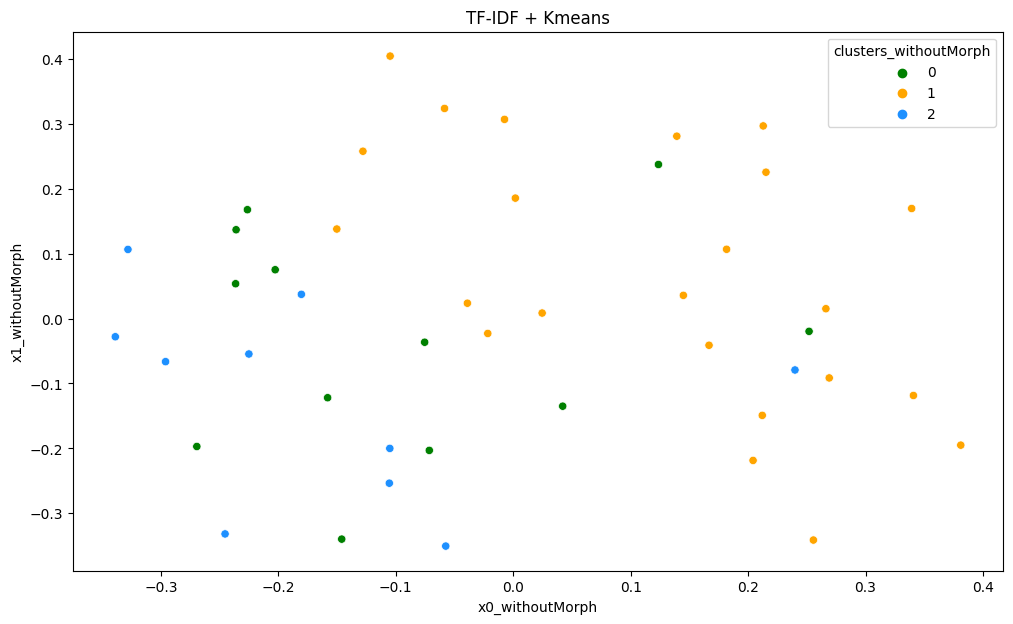

0.6666666666666666
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.60      1.00      0.75         6
           2       1.00      0.43      0.60         7

    accuracy                           0.67        18
   macro avg       0.73      0.68      0.65        18
weighted avg       0.76      0.67      0.65        18



In [793]:
def _getVectorizer(fieldName):
    vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
    x = vectorizer.fit_transform(dfFTales[fieldName])
    return x

def _getClusters(x, fieldName):
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(x)
    clusters = kmeans.labels_
    dfFTales[fieldName] = clusters

def _pca(x, fieldX0, fieldX1, fieldCluster):
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(x.toarray())
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    dfFTales[fieldX0] = x0
    dfFTales[fieldX1] = x1

    plt.figure(figsize=(12, 7))
    plt.title("TF-IDF + Kmeans")
    plt.xlabel(fieldX0)
    plt.ylabel(fieldX1)
    sns.scatterplot(data=dfFTales, x=fieldX0, y=fieldX1, hue=fieldCluster, palette=['green', 'orange', 'dodgerblue'])
    plt.show()

def _calcAccuracy(x, fieldCluster):
    XVectorDf = pd.DataFrame(x.toarray())
    xTraining, xTest, yTraining, yTest = train_test_split(XVectorDf, dfFTales[fieldCluster], test_size = 0.4, random_state=42)

    knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski')
    knn.fit(xTraining, yTraining)
    predictions = knn.predict(xTest).tolist()

    print(accuracy_score(yTest, predictions))
    print(classification_report(yTest, predictions))


def processTfIdf(fieldData, fieldCluster, fieldX0, fieldX1):
    X = _getVectorizer(fieldData)
    _getClusters(X, fieldCluster)
    _pca(X, fieldX0, fieldX1, fieldCluster)
    _calcAccuracy(X, fieldCluster)
    


processTfIdf('formated', 'cluster', "x0", "x1")
processTfIdf('formated_withoutMorph', 'clusters_withoutMorph', "x0_withoutMorph", "x1_withoutMorph")


### Word2Vec

C:\Users\bryan\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


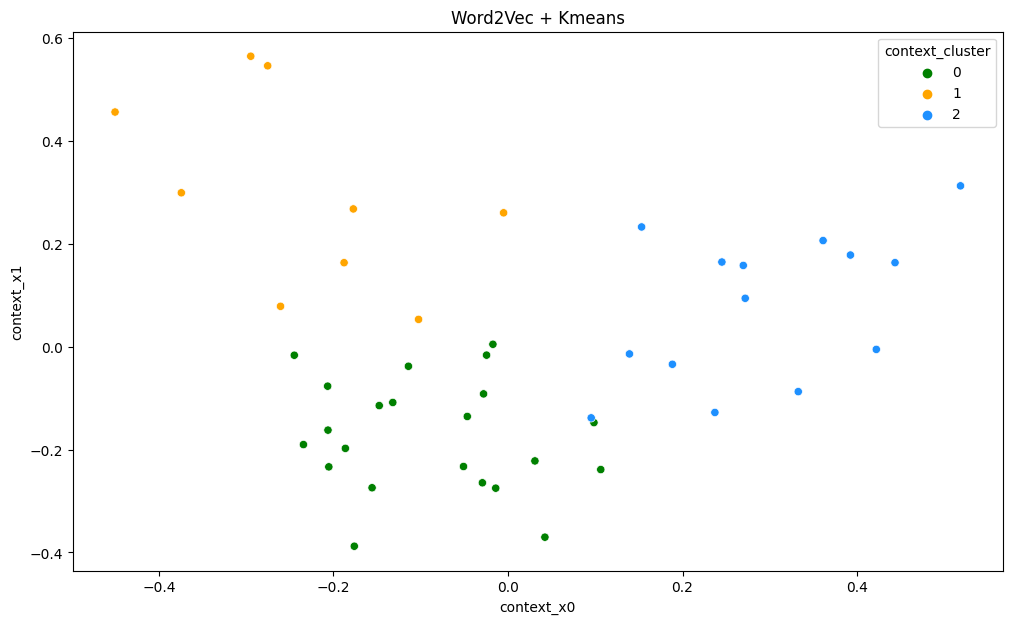

0.8333333333333334
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         9
           1       1.00      0.40      0.57         5
           2       1.00      1.00      1.00         4

    accuracy                           0.83        18
   macro avg       0.92      0.80      0.81        18
weighted avg       0.88      0.83      0.81        18



C:\Users\bryan\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


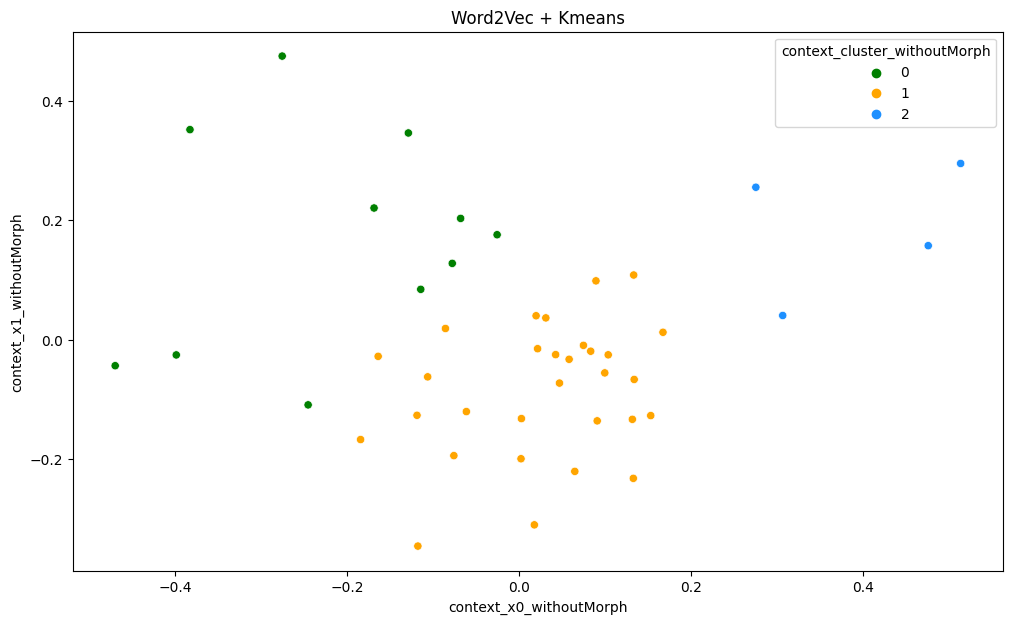

0.8888888888888888
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.83      1.00      0.91        10
           2       1.00      1.00      1.00         2

    accuracy                           0.89        18
   macro avg       0.94      0.89      0.90        18
weighted avg       0.91      0.89      0.88        18



In [810]:
def _get_w2vdf(fieldData):
    w2v_df = pd.DataFrame(dfFTales[fieldData]).values.tolist()
    for i in range(len(w2v_df)):
        w2v_df[i] = w2v_df[i][0].split(" ")
    return w2v_df

def _train_w2v(w2v_df):
    w2v_model = Word2Vec(min_count=1, size=100)
    
    w2v_model.build_vocab(w2v_df)
    w2v_model.train(w2v_df, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)
    return w2v_model

def _preprocess(s):
    return [i for i in s.split()]

def _get_vector(s, model):
    return np.sum(np.array([model[i] for i in _preprocess(s)]), axis=0)

def _pcaContext(x, fieldX0, fieldX1, fieldCluster):
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(x)
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]


    dfFTales[fieldX0] = x0
    dfFTales[fieldX1] = x1

    plt.figure(figsize=(12, 7))
    plt.title("Word2Vec + Kmeans")
    plt.xlabel(fieldX0)
    plt.ylabel(fieldX1)
    sns.scatterplot(data=dfFTales, x=fieldX0, y=fieldX1, hue=fieldCluster, palette=['green', 'orange', 'dodgerblue'])
    plt.show()

def _calcAccuracyContext(x, fieldCluster):
    XVectorDf = pd.DataFrame(x)
    xTraining, xTest, yTraining, yTest = train_test_split(XVectorDf, dfFTales[fieldCluster], test_size = 0.4, random_state=42)

    knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski')
    knn.fit(xTraining, yTraining)
    predictions = knn.predict(xTest).tolist()

    print(accuracy_score(yTest, predictions))
    print(classification_report(yTest, predictions))


def processContex(fieldData, fieldCluster, fieldX0, fieldX1):
    w2v_df = _get_w2vdf(fieldData)
    w2v_model = _train_w2v(w2v_df)

    x = [_get_vector(text, w2v_model) for text in dfFTales[fieldData]]
    x = normalize(x)

    _getClusters(x, fieldCluster)
    _pcaContext(x, fieldX0, fieldX1, fieldCluster)
    _calcAccuracyContext(x, fieldCluster)

processContex("formated", "context_cluster", "context_x0", "context_x1")
processContex("formated_withoutMorph", "context_cluster_withoutMorph", "context_x0_withoutMorph", "context_x1_withoutMorph")



In [795]:
# vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# X = vectorizer.fit_transform(dfFTales['formated'])

# vectorizer_withoutMorph = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# X_withoutMorph = vectorizer_withoutMorph.fit_transform(dfFTales['formated_withoutMorph'])

In [796]:
# kmeans = KMeans(n_clusters=3, random_state=42)
# kmeans.fit(X)
# clusters = kmeans.labels_
# dfFTales["clusters"] = clusters

# kmeans_withoutMorph = KMeans(n_clusters=3, random_state=42)
# kmeans_withoutMorph.fit(X_withoutMorph)
# clusters_withoutMorph = kmeans_withoutMorph.labels_
# dfFTales["clusters_withoutMorph"] = clusters_withoutMorph

In [797]:
# pca = PCA(n_components=2, random_state=42)
# pca_vecs = pca.fit_transform(X.toarray())
# x0 = pca_vecs[:, 0]
# x1 = pca_vecs[:, 1]

# pca_withoutMorph = PCA(n_components=2, random_state=42)
# pca_vecs_withoutMorph = pca_withoutMorph.fit_transform(X_withoutMorph.toarray())
# x0_withoutMorph = pca_vecs_withoutMorph[:, 0]
# x1_withoutMorph = pca_vecs_withoutMorph[:, 1]

In [798]:
# dfFTales["x0"] = x0
# dfFTales["x1"] = x1

# dfFTales["x0_withoutMorph"] = x0_withoutMorph
# dfFTales["x1_withoutMorph"] = x1_withoutMorph

In [799]:
dfFTales

,num_doc,text,class,formated,formated_withoutMorph,cluster,x0,x1,clusters_withoutMorph,x0_withoutMorph,x1_withoutMorph,context_cluster,context_x0,context_x1
0,1,"На краю деревни, у околицы стоял одинокий поко...",scan,край деревня околица стоять одинокий покоситьс...,краю деревни околицы стоял одинокий покосивший...,1,-0.096135,-0.260186,2,-0.105491,-0.253699,0,0.042318,-0.370258
1,2,"Жил когда-то в Финнмарке человек, который пойм...",scan,жить финнмарка человек который поймать белый м...,жил финнмарке человек который поймал белого ме...,0,0.114656,-0.240674,0,-0.202678,0.075296,0,-0.029335,-0.264543
2,3,Жил на свете крестьянин по имени Гудбранд. Уса...,scan,жить свет крестьянин имя гудбранд усадьба стоя...,жил свете крестьянин имени гудбранд усадьба ст...,1,-0.236005,0.071164,0,0.251911,-0.019678,0,-0.206658,-0.076761
3,4,Жили в одном селе две вздорные соседки. Стоило...,scan,жить село вздорный соседка стоить увидеть друг...,жили одном селе две вздорные соседки стоило ув...,0,0.024482,0.218425,0,-0.071453,-0.203164,0,-0.024548,-0.016446
4,5,"В одной деревне жил у отца с матерью парень, п...",scan,деревня жить отец мать парень имя хальвор жить...,одной деревне жил отца матерью парень имени ха...,2,0.023063,-0.045500,0,-0.236377,0.053737,0,0.098521,-0.147582
5,6,"Жила-была старая женщина, и был у нee сын женщ...",scan,жить старый женщина нee сын женщина слабый бол...,жила старая женщина нee сын женщина слабая бол...,1,-0.161541,0.017833,1,0.269078,-0.091474,0,-0.114084,-0.038056
6,7,Задумал один крестьянский парень жениться. И х...,scan,задумать крестьянский парень жениться хотеться...,задумал крестьянский парень жениться хотелось ...,1,-0.075508,-0.359831,0,0.042121,-0.135018,0,-0.176112,-0.387841
7,8,Жила в Треннелагской округе бедная женщина. Не...,scan,жить треннелагский округ бедный женщина кола д...,жила треннелагской округе бедная женщина кола ...,1,-0.145986,-0.155860,1,0.024621,0.008553,0,-0.155754,-0.274196
8,9,Как-то раз под вечер одна Курица взлетела на в...,scan,вечер курица взлететь ветка большой дуб уснуть...,вечер одна курица взлетела ветку большого дуба...,0,0.025582,-0.139465,2,-0.057455,-0.350648,0,-0.027990,-0.091753
9,10,В стародавние времена у одного короля было две...,scan,стародавний время король двенадцать сын выраст...,стародавние времена одного короля двенадцать с...,1,-0.135723,-0.156927,1,-0.127972,0.257951,0,-0.147534,-0.114501


In [800]:
# plt.figure(figsize=(12, 7))
# plt.title("TF-IDF + Kmeans")
# plt.xlabel("X0")
# plt.ylabel("X1")
# sns.scatterplot(data=dfFTales, x='x0', y='x1', hue='clusters', palette=['green', 'orange', 'dodgerblue'])
# plt.show()

In [801]:
# plt.figure(figsize=(12, 7))
# plt.title("TF-IDF + Kmeans")
# plt.xlabel("X0_withoutMorph")
# plt.ylabel("X1_withoutMorph")
# sns.scatterplot(data=dfFTales, x='x0_withoutMorph', y='x1_withoutMorph', hue='clusters_withoutMorph', palette=['green', 'orange', 'dodgerblue'])
# plt.show()

In [802]:
# def get_w2vdf():
#     w2v_df = pd.DataFrame(dfFTales["formated"]).values.tolist()
#     for i in range(len(w2v_df)):
#         w2v_df[i] = w2v_df[i][0].split(" ")
#     return w2v_df

# w2v_df = get_w2vdf()

In [803]:
# def train_w2v(w2v_df):
#     w2v_model = Word2Vec(min_count=1, size=100)
    
#     w2v_model.build_vocab(w2v_df)
#     w2v_model.train(w2v_df, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)
#     return w2v_model

# w2v_model = train_w2v(w2v_df)

In [804]:
# from sklearn.preprocessing import normalize

# def preprocess(s):
#     return [i for i in s.split()]

# def get_vector(s):
#     # return np.sum(np.array([w2v_model[i] for i in preprocess(s)]), axis=0)

# resVecArr = [get_vector(text) for text in dfFTales['formated']]
# resVecArr = normalize(resVecArr)

In [805]:
# kmeans = KMeans(n_clusters=3, random_state=42)
# kmeans.fit(resVecArr)
# clusters = kmeans.labels_
# dfFTales["sos"] = clusters

In [806]:
# pca = PCA(n_components=2, random_state=42)
# pca_vecs = pca.fit_transform(resVecArr)
# x0 = pca_vecs[:, 0]
# x1 = pca_vecs[:, 1]


# dfFTales["x0_sos"] = x0
# dfFTales["x1_sos"] = x1

# plt.figure(figsize=(12, 7))
# plt.title("TF-IDF + Kmeans")
# plt.xlabel("X0_withoutMorph")
# plt.ylabel("X1_withoutMorph")
# sns.scatterplot(data=dfFTales, x='x0_sos', y='x1_sos', hue='sos', palette=['green', 'orange', 'dodgerblue'])
# plt.show()

In [807]:
# XVectorDf = pd.DataFrame(X.toarray())
# xTraining, xTest, yTraining, yTest = train_test_split(XVectorDf, dfFTales['clusters'], test_size = 0.4, random_state=42)

# classes_names = ['0','1', '2']

# # knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski')
# knn.fit(xTraining, yTraining)
# predictions = knn.predict(xTest).tolist()

# print(accuracy_score(yTest, predictions))
# print(classification_report(yTest, predictions))

In [808]:
# XVectorDf_withoutMorph = pd.DataFrame(X_withoutMorph.toarray())
# xTraining, xTest, yTraining, yTest = train_test_split(XVectorDf_withoutMorph, dfFTales['clusters_withoutMorph'], test_size = 0.4, random_state=42)

# classes_names = ['0','1', '2']

# knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski')
# knn.fit(xTraining, yTraining)
# predictions = knn.predict(xTest).tolist()

# print(accuracy_score(yTest, predictions))
# print(classification_report(yTest, predictions))

In [809]:
# XVectorDf = pd.DataFrame(resVecArr)
# xTraining, xTest, yTraining, yTest = train_test_split(XVectorDf, dfFTales['sos'], test_size = 0.4, random_state=42)

# classes_names = ['0','1', '2']

# knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski')
# knn.fit(xTraining, yTraining)
# predictions = knn.predict(xTest).tolist()

# print(accuracy_score(yTest, predictions))
# print(classification_report(yTest, predictions))